Import Libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

Load Dataset

In [ ]:
dataset = pd.read_csv('BTC.csv', index_col='Date', parse_dates=['Date'])
dataraw = dataset.copy()
dataraw

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,2.412760e+07
...,...,...,...,...,...,...
2023-04-07,28038.966800,28111.593750,27794.031250,27925.859380,27925.859380,1.086168e+10
2023-04-08,27920.513670,28159.863280,27883.386720,27947.794920,27947.794920,9.373256e+09
2023-04-09,27952.367190,28532.830080,27828.480470,28333.050780,28333.050780,1.217532e+10


Visualization on Closing Prices

 Count row of data:  3128


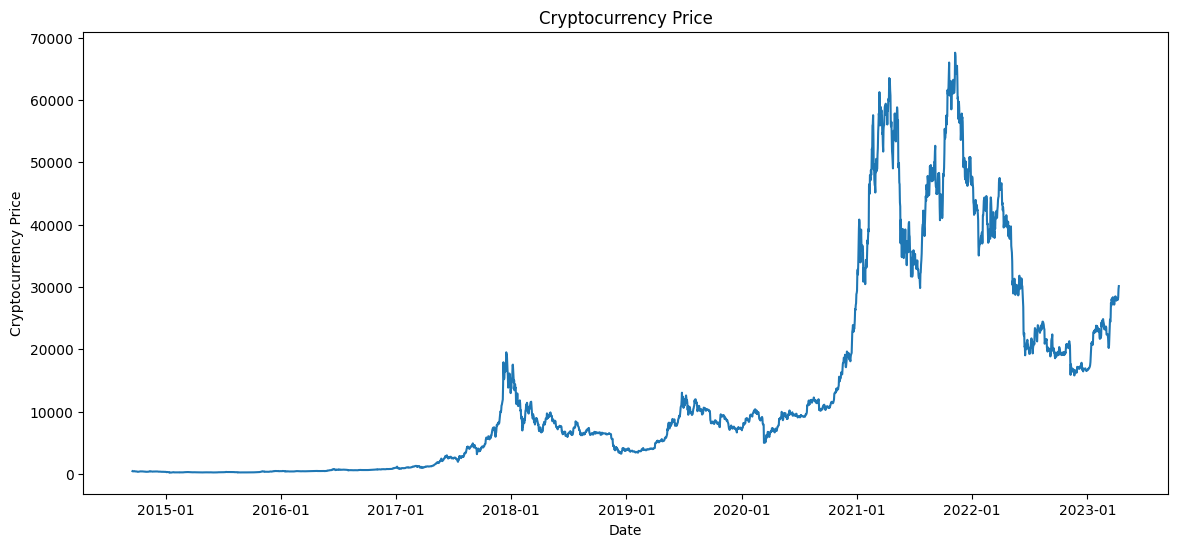

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(dataraw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Cryptocurrency Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Cryptocurrency Price')
plt.show()

Normalization

In [ ]:
# Extract only the 'Close' price for simplicity
dataset = dataraw[['Close']]

# Min-Max Normalization (fit only on training data to avoid data leakage)
scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset)

Train-Valid-Test

In [ ]:
dates = dataraw.index
# Partition data into train, val & test (70% train, 15% validation, 15% test)
total_len = len(dataset_norm)
train_size = int(total_len * 0.7)
val_size = int(total_len * 0.15)

train_data = dataset_norm[:train_size]
val_data = dataset_norm[train_size:train_size+val_size]
test_data = dataset_norm[train_size+val_size:]

# Extract the corresponding dates for the training set
train_dates = dates[:train_size]
val_dates = dates[train_size:train_size+val_size]
test_dates = dates[train_size+val_size:]

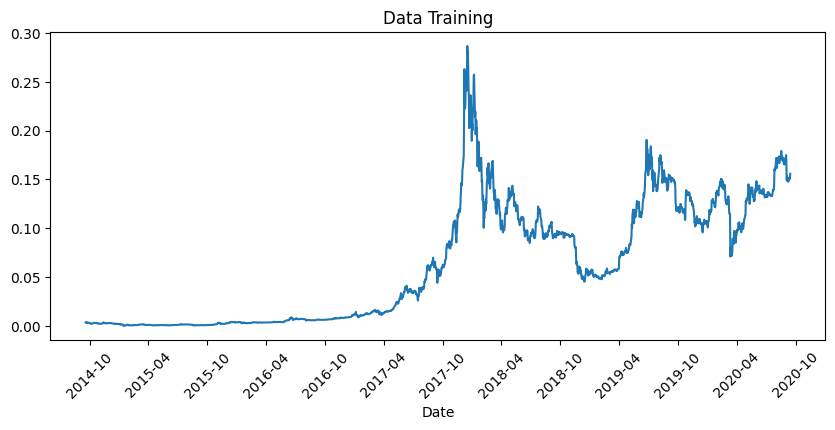

In [ ]:
# Plot graph of the training data with dates
fig = plt.figure(figsize=(10, 4))
plt.plot(train_dates, train_data)  # Plot using the extracted training dates
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show every 6 months (adjust as needed)
plt.title('Data Training')
plt.xticks(rotation=45)
plt.show()

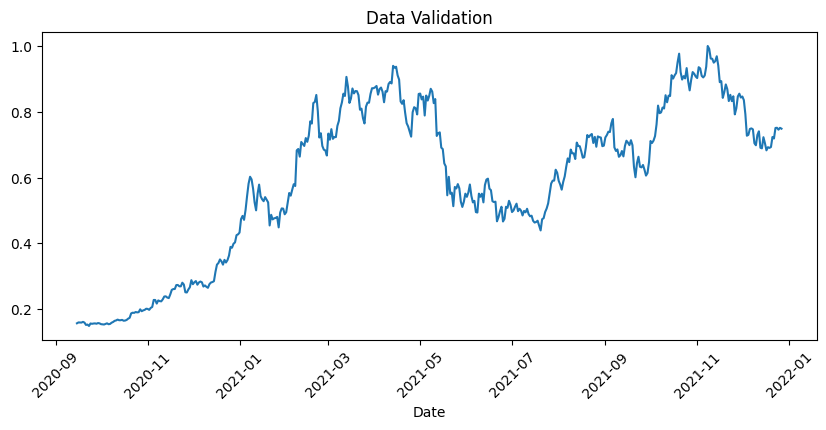

In [ ]:
# Plot graph of the validation data with dates
fig = plt.figure(figsize=(10, 4))
plt.plot(val_dates, val_data)  # Plot using the extracted validation dates
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Validation')
plt.xticks(rotation=45)
plt.show()

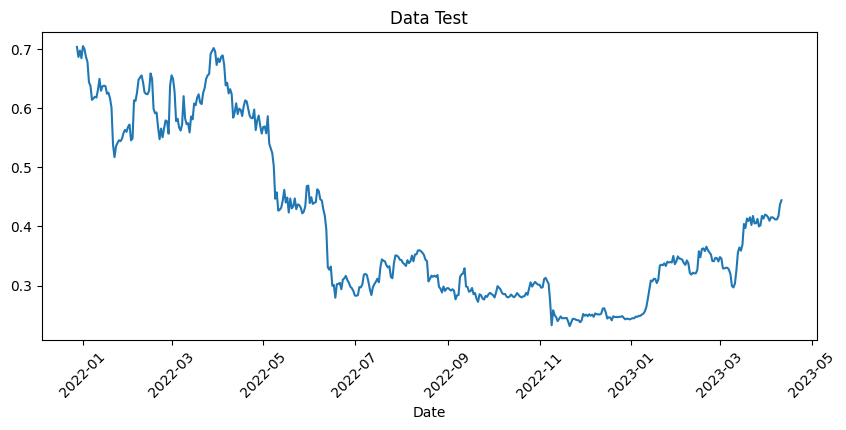

In [ ]:
# Plot graph of the test data with dates
fig = plt.figure(figsize=(10, 4))
plt.plot(test_dates, test_data)  # Plot using the extracted testing dates
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Test')
plt.xticks(rotation=45)
plt.show()

Sliding Windows

In [ ]:
# Function to create sliding windows
def create_sliding_windows(data, lag):
    x, y = [], []
    for i in range(lag, len(data)):
        x.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Set lag value based on autocorrelation analysis
lag = 3

# Create sliding windows for training, validation, and test sets
x_train, y_train = create_sliding_windows(train_data, lag)
x_val, y_val = create_sliding_windows(val_data, lag)
x_test, y_test = create_sliding_windows(test_data, lag)

# Reshape for LSTM/GRU input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


Train Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Hyperparameters
learning_rate = 0.001
hidden_unit = 128
batch_size = 64
epochs = 200

# Initialize the model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

# Second GRU layer with dropout
model.add(GRU(units=hidden_unit, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Third LSTM layer without return_sequences
model.add(LSTM(units=hidden_unit // 2, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    verbose=1,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0011 - val_loss: 0.2192
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0064 - val_loss: 0.2799
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0110 - val_loss: 0.2699
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0082 - val_loss: 0.2360
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - val_loss: 0.0241
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020 - val_loss: 0.0199
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.1173e-04 - val_loss: 0.0098
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.8385e-04 - val_loss: 0.0095
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.4233e-04 - val_loss: 0.0067
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3515e-04 - val_loss: 0.0033
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.0569e-05 - val_loss: 0.0020
Epoch 12/200
35/35 ━━━━━━━━━━━━━

Model Loss

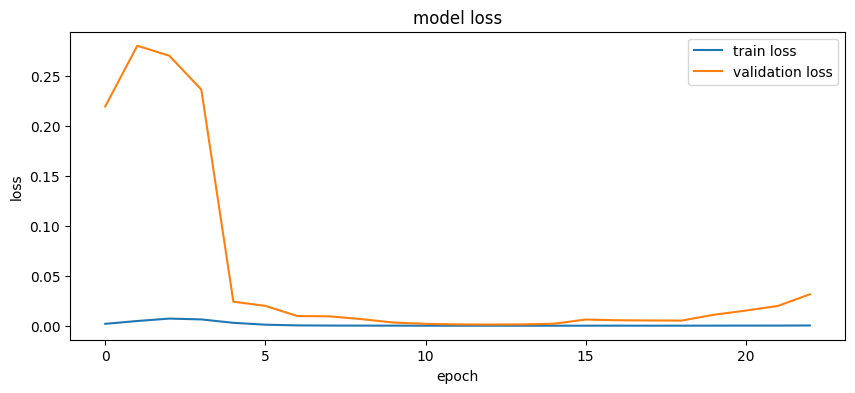

In [ ]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Learning Rate & Model Loss

In [ ]:
# label value of training loss & validation loss
learningrate_parameter = learning_rate
train_loss=history.history['loss'][-1]
validation_loss=history.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.001,0.000364,0.031504


Model Evaluation

In [ ]:
# Predict on test data
predicted_test = model.predict(x_test)

# Invert normalization
predicted_test_inverted = scaler.inverse_transform(predicted_test)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inverted, predicted_test_inverted)
mae = mean_absolute_error(y_test_inverted, predicted_test_inverted)
print(f"MSE: {mse}, MAE: {mae}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
MSE: 1971355.428590448, MAE: 993.1301255105728


Invert Normalization

In [ ]:
# trained the model and predicted on the test set
y_pred_test = model.predict(x_test)

# Invert normalization to get the original scale of predictions
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Compare the Actual data with predicted data

In [ ]:
# Comparison of test data with prediction
datacompare = pd.DataFrame()

# Ensure that datatest and datapred have the same length
datatest = np.array(dataset['Close'][train_size + val_size + lag:train_size + val_size + lag + len(y_pred_invert_norm)])

datapred = y_pred_invert_norm.flatten()  # Flatten to 1D if necessary

# Add columns to the DataFrame
datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred

# Show the result
datacompare.head()  # Print the first few rows to check


,Data Test,Prediction Results
0,46306.44531,47093.125000
1,47686.81250,46614.304688
2,47345.21875,46908.375000
3,46458.11719,46842.402344
4,45897.57422,47324.519531


Calculate RMSE MAPE

In [ ]:
# Calculatre value of Root Mean Square Error
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :',rmse(datatest, datapred))

def mape(datatest, datapred):
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)

print('Result Mean Absolute Percentage Error Prediction Model : ', mape(datatest, datapred), '%')

Result Root Mean Square Error Prediction Model : 1404.0497
Result Mean Absolute Percentage Error Prediction Model :  3.6664 %


Visualize the Comparison of Actual Test Data and Predicted Data

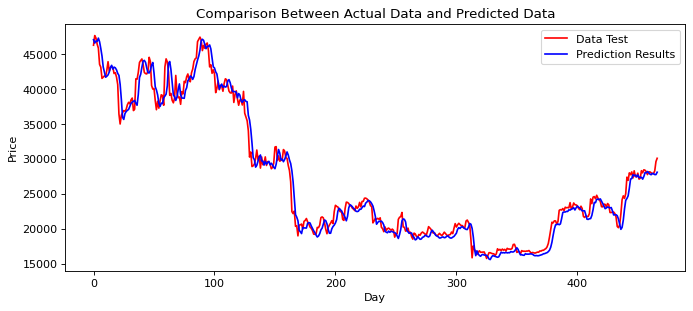

In [ ]:
# Create graph data test and prediction result
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Comparison Between Actual Data and Predicted Data')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

Result- Predicting Future Prices

In [ ]:
from datetime import datetime, timedelta
# Predict the next 5 days after the test set
last_lag_days = dataset_norm[-lag:]  # Last 'lag' days of normalized data
last_lag_days_reshaped = np.reshape(last_lag_days, (1, lag, 1))

predicted_future_prices = []
for i in range(5):
    next_day_prediction = model.predict(last_lag_days_reshaped)
    predicted_future_prices.append(next_day_prediction[0][0])

    # Update the input for the next prediction
    last_lag_days = np.append(last_lag_days[1:], next_day_prediction)
    last_lag_days_reshaped = np.reshape(last_lag_days, (1, lag, 1))

# Invert normalization for future predictions
predicted_future_prices_inverted = scaler.inverse_transform(np.array(predicted_future_prices).reshape(-1, 1))

# Generate future dates
last_date = dataraw.index[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(5)]

# Print predictions
for date, price in zip(future_dates, predicted_future_prices_inverted):
    print(f"Date: {date.strftime('%Y-%m-%d')}, Predicted Price: {price[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Date: 2023-04-12, Predicted Price: 28853.96
Date: 2023-04-13, Predicted Price: 29545.10
Date: 2023-04-14, Predicted Price: 29480.53
Date: 2023-04-15, Predicted Price: 29007.28
Date: 2023-04-16, Predicted Price: 29293.57
